In [2]:
import numpy as np
import matplotlib.pyplot as plt
from prefactors import GTO_prefactor_LG
from OutputInterface import OutputInterface

In [54]:
from scipy.special import binom
from scipy.special import gamma
def binom_method(px, py, pz, z0, i, j, k, alpha, N, A, E):
    """
    Binomial method for finding the prefactor for a GTO
    """
    pz = pz + A

    #N = (2*alpha/np.pi)**(3/4) * np.sqrt((8*alpha)**(i+j+k) * np.math.factorial(i) \
    #    * np.math.factorial(j) * np.math.factorial(k) / (np.math.factorial(2*i) \
    #    * np.math.factorial(2*j) * np.math.factorial(2*k)))

    Ix = np.exp(-px**2/(4*alpha))
    Iy = np.exp(-py**2/(4*alpha))
    Iz = np.exp(-pz**2/(4*alpha)) * np.exp(-1j*pz*z0) #*np.exp(-1j*pz*2*z0)  # This term should be like this?

    sum_x = 0
    sum_y = 0
    sum_z = 0
    for nx in range(i+1):
        sum_x += binom(i,nx) * (-1j*px/(2*alpha))**(i-nx) * 0.5 * (1+(-1)**nx) * alpha**(-(1+nx)/2) * gamma((1+nx)/2)

    for ny in range(j+1):
        sum_y += binom(j,ny) * (-1j*py/(2*alpha))**(j-ny) * 0.5 * (1+(-1)**ny) * alpha**(-(1+ny)/2) * gamma((1+ny)/2)

    for nz in range(k+1):
        sum_z += binom(k,nz) * (-1j*pz/(2*alpha))**(k-nz) * ( (z0-1j*pz/(2*alpha)) * 0.5*(1+(-1)**nz) * alpha**(-(1+nz)/2) * gamma((1+nz)/2) \
            + 0.5*(1+(-1)**(nz+1)) *alpha**(-(nz+2)/2)*gamma((nz+2)/2) )

    return N/(2*np.pi)**(3/2) * sum_x*Ix * sum_y*Iy * sum_z*Iz * E

In [2]:
omega = 0.057     # Frequency of light?
Up = 0.22         # Ponderomotive potential
Ip = 0.579        # Ionization potential

dp = 4./250
pz_list = np.arange(-1.7, 1.7, dp)
px_list = np.arange(0, 1.7, dp)
#pz_grid, px_grid = np.meshgrid(pz_list, px_list)
py = 0

In [3]:
def Af(t):
    return 2*np.sqrt(Up) * np.cos(omega * t)

def Ef(t):
    return 2*np.sqrt(Up) * omega * np.sin(omega * t)

def saddle_times(p_par, p_perp, n):
    """
        Finds the saddle point times for a monochromatic wave A = 2*sqrt(Up) cos(omega * t). See Eq. (4.4) in Andrew's thesis.
        p_par : parallel momentum (pz)
        p_perp : perpendicular momentum
    """
    t1 =  2*np.pi*n/omega + 1/omega * np.arccos((-p_par - 1j*np.sqrt(2*Ip + p_perp**2)) / (2*np.sqrt(Up)))
    t2 =  2*np.pi*n/omega - 1/omega * np.arccos((-p_par + 1j*np.sqrt(2*Ip + p_perp**2)) / (2*np.sqrt(Up)))
    return t1, t2

In [3]:
inter = OutputInterface('output_files/Hydrogen.out')
GTO_coeffs = inter.output_GTOs()  # HOMO orbital coeffs

### Try with Hermite GTO prefacor function

In [63]:
d_grid = np.zeros((len(pz_list), len(px_list)), dtype=complex)
for m,pz in enumerate(pz_list):
    for n,px in enumerate(px_list):
        ts = saddle_times(pz,px,0)[0]
        #print(ts, Af(ts), Ef(ts))
        for coeffs in GTO_coeffs:
            N, alpha, i, j, k, x0, y0, z0 = coeffs
            #print(GTO_prefactor_LG(px, py, pz, x0, y0, z0, i, j, k, alpha, N, Af(ts), Ef(ts)))
            d_grid[m,n] += GTO_prefactor_LG(px, py, pz, x0, y0, z0, i, j, k, alpha, N, Af(ts), Ef(ts))

d_square = np.abs(d_grid)**2
d_max = np.max(d_square)

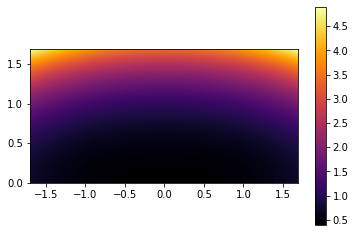

In [64]:
plt.imshow(np.flip(d_square.T,0), cmap='inferno', aspect=1, interpolation = 'bicubic', #norm=LogNorm(vmin=M_max*1e-6, vmax=M_max),
           extent = (np.amin(pz_list), np.amax(pz_list), np.amin(px_list), np.amax(px_list)))
plt.colorbar()

### Try with bionmial version

In [65]:
d_grid = np.zeros((len(pz_list), len(px_list)), dtype=complex)
for m,pz in enumerate(pz_list):
    for n,px in enumerate(px_list):
        ts = saddle_times(pz,px,0)[0]
        for coeffs in GTO_coeffs:
            N, alpha, i, j, k, x0, y0, z0 = coeffs
            d_grid[m,n] += binom_method(px, py, pz, z0, i, j, k, alpha, N, Af(ts), Ef(ts))

d_square = np.abs(d_grid)**2
d_max = np.max(d_square)

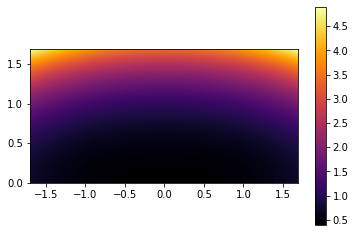

In [66]:
plt.imshow(np.flip(d_square.T,0), cmap='inferno', aspect=1, interpolation = 'bicubic', #norm=LogNorm(vmin=M_max*1e-6, vmax=M_max),
           extent = (np.amin(pz_list), np.amax(pz_list), np.amin(px_list), np.amax(px_list)))
plt.colorbar()

### The two methods seem to agree. But it still does not look like what we would think? Let's try to compare with the numerical calculation of the integrals.. Going to take forever..

In [68]:
from scipy.integrate import tplquad

def GTO(x, y, z, x0, y0, z0, i, j, k, alpha):
    xd = x-x0
    yd = y-y0
    zd = z-z0
    N = (2*alpha/np.pi)**(3/4) * np.sqrt((8*alpha)**(i+j+k) * np.math.factorial(i) \
        * np.math.factorial(j) * np.math.factorial(k) / (np.math.factorial(2*i) \
        * np.math.factorial(2*j) * np.math.factorial(2*k)))
    return N * xd**i * yd**j * zd**k * np.exp(-alpha*(xd**2 + yd**2 + zd**2))

def func(x,y,z):
    res = np.exp(-1j*(px*x + py*y + pz*z + z*A)) * E*z * GTO(x,y,z,x0,y0,z0,i,j,k,alpha)
    return 1/(2*np.pi)**(3/2) * res

def cmplx_quad(func, a, b):
    def real_func(x,y,z):
        return np.real(func(x,y,z))

    def imag_func(x,y,z):
        return np.imag(func(x,y,z))
    real_integral = tplquad(real_func, a, b, a, b, a, b, epsabs=1e-4, epsrel=1e-4)
    imag_integral = tplquad(imag_func, a, b, a, b, a, b, epsabs=1e-4, epsrel=1e-4)
    return [real_integral[0] + 1j*imag_integral[0], real_integral[1:], imag_integral[1:]]

In [73]:
dp = 2/250
pz_list = np.arange(-1.3, 1.3, dp)
px_list = np.arange(0, 1., dp)

d_grid = np.zeros((len(pz_list), len(px_list)), dtype=complex)
for m,pz in enumerate(pz_list):
    print(m)
    for n,px in enumerate(px_list):
        ts = saddle_times(pz,px,0)[0]
        E = Ef(ts)
        A = Af(ts)
        for coeffs in GTO_coeffs:
            N, alpha, i, j, k, x0, y0, z0 = coeffs
            d_grid[m,n] += cmplx_quad(func, -np.inf, np.inf)[0]

d_square = np.abs(d_grid)**2
d_max = np.max(d_square)

0


/tmp/ipykernel_6181/806930514.py:13: RuntimeWarning: overflow encountered in exp
  res = np.exp(-1j*(px*x + py*y + pz*z + z*A)) * E*z * GTO(x,y,z,x0,y0,z0,i,j,k,alpha)
/tmp/ipykernel_6181/806930514.py:13: RuntimeWarning: invalid value encountered in cdouble_scalars
  res = np.exp(-1j*(px*x + py*y + pz*z + z*A)) * E*z * GTO(x,y,z,x0,y0,z0,i,j,k,alpha)


KeyboardInterrupt: 

### Let's try to calculate the SFA transition amplitude without the saddlepoint approximation!

In [4]:
inter = OutputInterface('output_files/Hydrogen.out')
GTO_coeffs = inter.output_GTOs()  # HOMO orbital coeffs

In [33]:
from scipy.integrate import quad

omega = 0.057     # Frequency of light
Up = 0.22         # Ponderomotive potential
Ip = 0.579        # Ionization potential

def Af(t):
    #return 2*np.sqrt(Up) * np.cos(omega * t + np.pi/2)
    N = 10
    if t < 0 or t > 2*N*np.pi/omega:
        return 0
    else:
        return 2*np.sqrt(Up) * np.sin(omega*t/(2*N))**2 * np.cos(omega*t + np.pi/2)

def Ef(t):
    #return 2*np.sqrt(Up) * omega * np.sin(omega * t + np.pi/2)
    N = 10
    if t < 0 or t > 2*N*np.pi/omega:
        return 0
    else:
        factor1 = - 2*np.sin(omega*t/(2*N)) * omega/(2*N) * np.cos(omega*t/(2*N)) * np.cos(omega*t + np.pi/2)
        factor2 = omega * np.sin(omega*t/(2*N))**2 * np.sin(omega*t + np.pi/2)
        return 2*np.sqrt(Up) * (factor1 + factor2)

def action_integrand(tau, p, theta):
    return p * np.cos(theta) * Af(tau) + 0.5 * Af(tau)**2

def action_integral(t, p, theta):
    s1 = (Ip + 0.5*p**2)*t
    s2,s2_err = quad(action_integrand, 0, t, args=(p,theta), limit=1000)
    return s1 + s2

def M_integrand(t, px, py, pz, real):
    p = np.sqrt(px**2 + py**2 + pz**2)
    theta = np.arccos(pz/p)

    d0 = 0
    for coeffs in GTO_coeffs:
        N, alpha, i, j, k, x0, y0, z0 = coeffs
        d0 += GTO_prefactor_LG(px, py, pz, x0, y0, z0, i, j, k, alpha, N, Af(t), Ef(t))
    M0 = action_integral(t, p, theta) * d0

    if real:
        return np.real(M0)
    else:
        return np.imag(M0)

def trans_amp(px, py, pz):
    limit = 2*N*np.pi/omega #2*np.pi/omega
    M_real, real_err = quad(M_integrand, 0, limit, args=(px, py, pz, True), limit=1000)
    M_imag, imag_err = quad(M_integrand, 0, limit, args=(px, py, pz, False), limit=1000)
    return M_real + 1j * M_imag

In [35]:
N = 10
pz_list = np.linspace(-1.7, 1.7, 2*N)
px_list = np.linspace(0, 1.7, N)
py = 0

M_grid = np.zeros((len(pz_list), len(px_list)), dtype=complex)
for m,pz in enumerate(pz_list):
    print(m)
    for n,px in enumerate(px_list):
        M_grid[m,n] = trans_amp(px, py, pz)

M_square = np.abs(M_grid)**2

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


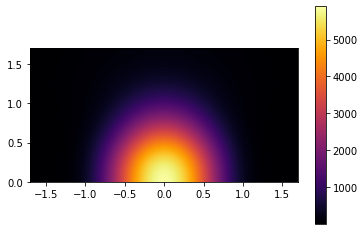

In [36]:
plt.imshow(np.flip(M_square.T,0), cmap='inferno', aspect=1, interpolation = 'bicubic', #norm=LogNorm(vmin=M_max*1e-6, vmax=M_max),
           extent = (np.amin(pz_list), np.amax(pz_list), np.amin(px_list), np.amax(px_list)))
plt.colorbar()

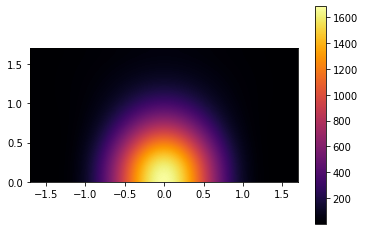

In [32]:
plt.imshow(np.flip(M_square.T,0), cmap='inferno', aspect=1, interpolation = 'bicubic', #norm=LogNorm(vmin=M_max*1e-6, vmax=M_max),
           extent = (np.amin(pz_list), np.amax(pz_list), np.amin(px_list), np.amax(px_list)))
plt.colorbar()